<span style="font-size: 14pt">EREVAN, May-June 2017</span>

<span style="font-size: 16pt"> Seminar #2: Exponential smoothing models

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>


<h1 align="center"> Home Work 1 </h1>

## Answer questions

### 1) ** How do adaptive properties of SES change when smoothing parametr $\alpha$ converges to 1?**

SES depends more on the last previous values (not the whole history), where the last values are given more weights




--------

### 2)  ** What will be the optimal value of smoothing parameter of trend $\beta$ in Hold model for 1) time series with slowly  changing trend; 2) stochastic changing trend (look <a href="http://stochastictrend.blogspot.am/">here </a>)? **


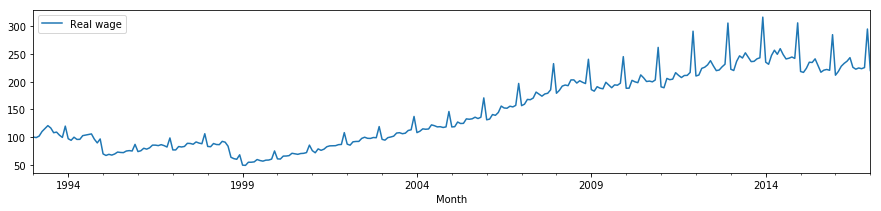

In [8]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

ts = pd.read_csv('./data/mothly_wage.csv', sep=';', decimal='.', index_col='Month', parse_dates=True, dayfirst=True)

ts.plot(figsize=(15,3))

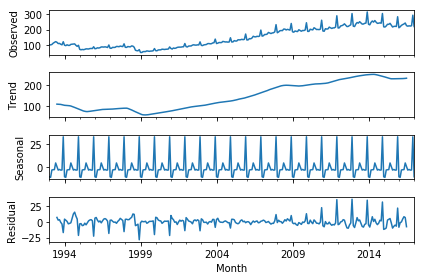

In [11]:
res = sm.tsa.seasonal_decompose(ts['Real wage'].loc['1993-01-01':'2017-01-01'].resample("M").sum())
resplot = res.plot()

trend =res.trend

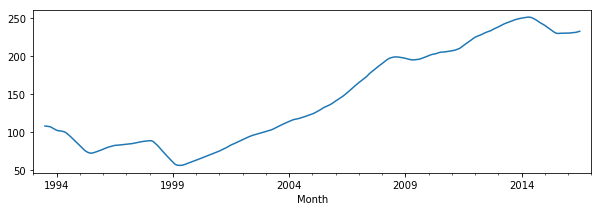

In [16]:
trend.plot(figsize = (10,3))

time series with slowly changing trend: from beginning until 1999 

time series with stochastic changing trend: from 1999 until 2008

In [18]:
## Loss function
def qualityRMSE(x,y):
    # Root mean squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return (((x-y)**2).mean())**(0.5) , (x-y)**2

In [19]:
def HoltWageExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    b= 0
    l= 0               # initialize ts level 
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= x[cntr]# initialize 
            
            if math.isnan(b):
                b= x[cntr]# initialize 
               
            l_saved = l
            
            l = alpha * x[cntr] + (1 - alpha) * (l + b)            # recurrent smoothing of level 
            b = beta * (l - l_saved) + (1 - beta) * b              # recurrent smoothing of trend            
            
        FORECAST[cntr+h] = l + b*h 
    return FORECAST

In [94]:
h = 1
start = ts.index[-1]+timedelta(1)
end = ts.index[-1]+timedelta(h)
rng = pd.date_range(start, end)
ts1 = ts.loc[:'1998-1']
frc_ts = pd.DataFrame(index = ts1.index.append(rng), columns = ts.columns)

ALPHA = np.arange(0.1, 1, 0.05)

min_loss= math.inf
min_beta = 0
loss_beta_stoc = []
alpha = 0.33

for beta in ALPHA:
        Params={'alpha':alpha, 'beta':beta, 'seasonality_period':12}
        for cntr in ts1.columns:
            x = np.array(ts1[cntr])
            frc_ts[cntr] = HoltWageExponentialSmoothing(x, h, Params)
            

        Quality, _ = qualityRMSE(ts1 , frc_ts)
        loss_beta_stoc.append(Quality[0])
        
        if(min_loss > Quality[0]):
            min_loss = Quality[0]
            min_beta = beta
        #print('alpha:', alpha,'beta:', beta, ' delta:', delta ,'loss:',  Quality[0])

print()
print('beta:', min_beta, 'loss:',  min_loss)


beta: 0.95 loss: 14.5078533202


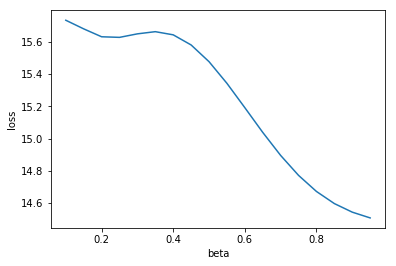

In [95]:
plt.plot(ALPHA, loss_beta_stoc)
plt.xlabel('beta')
plt.ylabel('loss')

In [96]:
h = 1
start = ts.index[-1]+timedelta(1)
end = ts.index[-1]+timedelta(h)
rng = pd.date_range(start, end)
ts1 = ts.loc['1999':'2008']
frc_ts = pd.DataFrame(index = ts1.index.append(rng), columns = ts.columns)

ALPHA = np.arange(0.1, 1, 0.05)

min_loss= math.inf
min_beta = 0
loss_beta_slow = []
alpha = 0.33

for beta in ALPHA:
        Params={'alpha':alpha, 'beta':beta, 'seasonality_period':12}
        for cntr in ts1.columns:
            x = np.array(ts1[cntr])
            frc_ts[cntr] = HoltWageExponentialSmoothing(x, h, Params)
            

        Quality, _ = qualityRMSE(ts1 , frc_ts)
        loss_beta_slow.append(Quality[0])
        
        if(min_loss > Quality[0]):
            min_loss = Quality[0]
            min_beta = beta
        #print('alpha:', alpha,'beta:', beta, ' delta:', delta ,'loss:',  Quality[0])

print()
print('beta:', min_beta, 'loss:',  min_loss)


beta: 0.1 loss: 11.0466146968


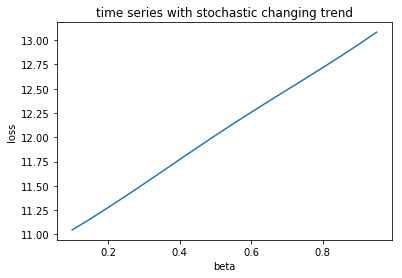

In [98]:
plt.plot(ALPHA, loss_beta_slow)
plt.xlabel('beta')
plt.ylabel('loss')
plt.title('time series with stochastic changing trend')

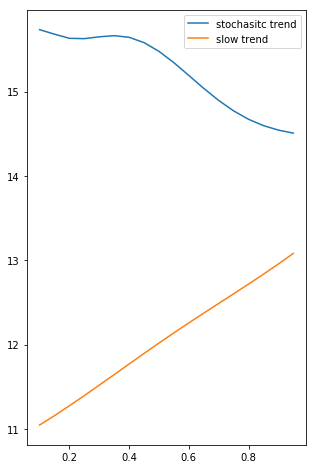

In [107]:
plt.figure(figsize = (5, 8))
plt.plot(ALPHA, loss_beta_stoc, label='stochasitc trend')
plt.plot(ALPHA, loss_beta_slow, label = 'slow trend')
plt.legend()

For stochastic changing trend, optimal value of beta is near 1, wherease for slowly changing trend optimal value for beta is near 0

---------

### 3) **Proof the equivalency of correction error form and smoothing form for unobserved component of TS in  Thei-Wage model (period of seasonality equals $p$):**

  $$l_t = \alpha (y_t - s_{t-p}) + (1-\alpha) (l_{t-1} + b_{t-1} )=l_{t-1} + b_{t-1} + \alpha e_t;$$
  $$ b_t = \beta (l_{t} - l_{t-1} ) + (1-\beta) b_{t-1} = b_{t-1} + \alpha\beta e_t;$$
  $$ s_t = \gamma (y_t-l_t) + (1-\gamma) s_{t-p} = s_{t-p} + \gamma(1-\alpha)e_t.$$




### <span style="color:red">$$l_t = \alpha (y_t - s_{t-p}) + (1-\alpha) (l_{t-1} + b_{t-1} )=l_{t-1} + b_{t-1} + \alpha e_t;$$</span>

$$\alpha (y_t - s_{t-p}) + l_{t-1} + b_{t-1} -\alpha (l_{t-1} + b_{t-1} )=l_{t-1} + b_{t-1} + \alpha e_t;$$
$$\alpha (y_t - s_{t-p}) -\alpha (l_{t-1} + b_{t-1} )=\alpha e_t$$ divide by $\alpha$:
$$y_t - s_{t-p} -l_{t-1} - b_{t-1} =e_t;$$
we have $\hat{y}_{t/t-1} = s_{t-p} + l_{t-1} + b_{t-1}$:

$$y_t - \hat{y}_{t/t-1} =e_t;$$


---

### <span style="color:red">$$ b_t = \beta (l_{t} - l_{t-1} ) + (1-\beta) b_{t-1} = b_{t-1} + \alpha\beta e_t;$$ </span>

$$ \beta (l_{t} - l_{t-1} )+  b_{t-1} -\beta b_{t-1} = b_{t-1} + \alpha\beta e_t;$$
$$ \beta (l_{t} - l_{t-1} ) -\beta b_{t-1} = \alpha\beta e_t;$$

from the first equation we have:$ l_t =l_{t-1} + b_{t-1} + \alpha e_t$:



$$ l_{t} - l_{t-1} - b_{t-1} = \alpha e_t;$$


----

### <span style="color:red">$$ s_t = \gamma (y_t-l_t) + (1-\gamma) s_{t-p} = s_{t-p} + \gamma(1-\alpha)e_t.$$ </span>
$$ \gamma (y_t-l_t)+ s_{t-p} -\gamma s_{t-p} = s_{t-p} + \gamma(1-\alpha)e_t.$$
$$ \gamma (y_t-l_t) -\gamma s_{t-p} = \gamma(1-\alpha)e_t.$$
$$ y_t-l_t -s_{t-p} = (1-\alpha)e_t.$$

divide by $\gamma$:

$$ y_t-l_t -s_{t-p} = (1-\alpha)e_t.$$
$$ y_t-l_t -s_{t-p} = e_t-\alpha e_t.$$

from the first equation we have: $ l_{t} - l_{t-1} - b_{t-1} = \alpha e_t$:

$$ y_t-l_t -s_{t-p} = e_t-  l_{t} + l_{t-1} + b_{t-1}.$$
$$ y_t -s_{t-p} = e_t + l_{t-1} + b_{t-1}.$$

we also have:
$e_t = y_t - \hat{y}_{t/t-1} = y_t - (s_{t-p} + l_{t-1} + b_{t-1})$:

$$ y_t -s_{t-p} = y_t - s_{t-p} - l_{t-1} - b_{t-1} + l_{t-1} + b_{t-1}.$$
$$ 0 = 0$$


---

### 4) **Find the correction error form for unobserved component of TS in ES with additive damped trend:**

$$\hat{y}_{t+d|t} = l_t + \left(\phi + \phi^2 + \dots + \phi^{d}\right) b_t.$$

**Unobserved components are (in smoothing form): **

$$ l_{t}       = \alpha y_t + \left(1-\alpha\right) \left(l_{t-1} +\phi b_{t-1}\right),$$
$$ b_t         = \beta \left(l_t - l_{t-1}\right) + \left(1-\beta\right)\phi b_{t-1}.$$

### <span style="color:red"> $$ l_{t}       = \alpha y_t + \left(1-\alpha\right) \left(l_{t-1} +\phi b_{t-1}\right),$$ </span>

$$ l_{t}  =\alpha y_t + l_{t-1} + \phi b_{t-1}-\alpha (l_{t-1} + \phi b_{t-1}),$$

we have: $\hat{y}_{t|t-1} = l_{t-1} + \phi b_{t-1}.$


$$ l_{t}  = \alpha y_t + l_{t-1} + \phi b_{t-1}-\alpha $\hat{y}_{t|t-1},$$

$$ l_{t}  =\alpha ( y_t - \hat{y}_{t|t-1}) + l_{t-1} + \phi b_{t-1},$$

we have: $e_{t} = y_t - \hat{y}_{t|t-1}$:

$$ l_{t}  =\alpha e_{t} + l_{t-1} + \phi b_{t-1},$$

$$ l_{t} = \alpha y_t + \left(1-\alpha\right) \left(l_{t-1} +\phi b_{t-1}\right)  =\alpha e_{t} + l_{t-1} + \phi b_{t-1},$$

----

### <span style="color:red">  $$ b_t         = \beta \left(l_t - l_{t-1}\right) + \left(1-\beta\right)\phi b_{t-1}.$$ </span>

we proved in the first quation that: $l_{t}  =\alpha e_{t} + l_{t-1} + \phi b_{t-1},$

$$ b_t = \beta \left(\alpha e_{t} + l_{t-1} + \phi b_{t-1} - l_{t-1}\right) + \left(1-\beta\right)\phi b_{t-1}.$$

$$ b_t = \beta \left(\alpha e_{t}  + \phi b_{t-1} \right) + \left(1-\beta\right)\phi b_{t-1}.$$

$$ b_t = \beta \alpha e_{t}  + \beta  \phi b_{t-1}  +  \phi b_{t-1} -\beta \phi b_{t-1}.$$

$$ b_t = \beta \alpha e_{t}  +  \phi b_{t-1} .$$

$$ b_t = \beta \left(l_t - l_{t-1}\right) + \left(1-\beta\right)\phi b_{t-1} = \beta \alpha e_{t}  +  \phi b_{t-1}.$$

---

# THE END